Final Project, Isabel and Wyatt

In [42]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz 
!pip install -q findspark

In [43]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [44]:
import findspark
findspark.init()

In [45]:
from pyspark import SparkConf, SparkContext
from pyspark import SparkFiles
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [46]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [47]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [48]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import concat, unix_timestamp
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.functions import split
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit
from pyspark.sql.types import DateType
from sklearn.metrics import r2_score


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
battingdata = spark.read.csv('drive/My Drive/Cloud Computing/PeopleBat.csv',inferSchema = True, header=True)
pitchingdata = spark.read.csv('drive/My Drive/Cloud Computing/PeoplePitch.csv',inferSchema = True, header=True)
fieldingOFdata = spark.read.csv('drive/My Drive/Cloud Computing/PeopleOF.csv',inferSchema = True, header=True)
salarydata = spark.read.csv('drive/My Drive/Cloud Computing/PeopleSalary.csv',inferSchema = True, header=True)

In [51]:
pitchingstats = pitchingdata.groupBy('age').agg(F.mean(F.col("ERA"))).toPandas()
pitchingstats = pitchingstats.sort_values(by=['age'])

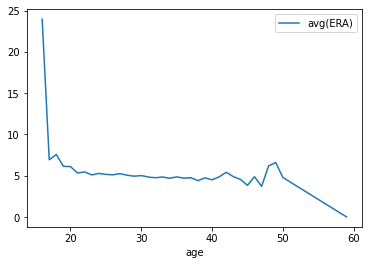

In [52]:
pitchingstats.plot(x = 'age', y = 'avg(ERA)')
plt.show()

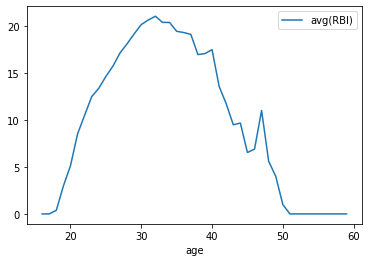

In [53]:
battingstats = battingdata.groupBy('age').agg(F.mean(F.col("RBI"))).toPandas()
battingstats = battingstats.sort_values(by=['age'])
battingstats.plot(x = 'age', y = 'avg(RBI)')
plt.show()

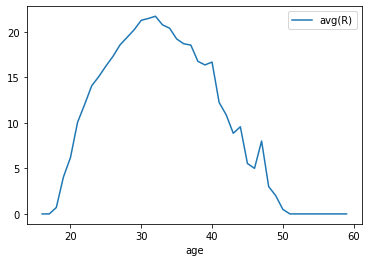

In [54]:
battingstats = battingdata.groupBy('age').agg(F.mean(F.col("R"))).toPandas()
battingstats = battingstats.sort_values(by=['age'])
battingstats.plot(x = 'age', y = 'avg(R)')
plt.show()

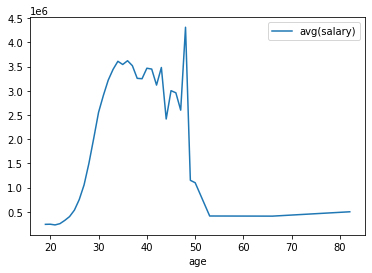

In [55]:
salarystats = salarydata.groupBy('age').agg(F.mean(F.col("salary"))).toPandas()
salarystats = salarystats.sort_values(by=['age'])
salarystats.plot(x = 'age', y = 'avg(salary)')
plt.show()

In [56]:
#batting = peopledata.join(battingdata, on=['playerID'], how='inner')
#fielding = peopledata.join(fieldingdata, on=['playerID'], how='inner')
#fieldingOF = peopledata.join(fieldingOFdata, on=['playerID'], how='inner')
#pitching =peopledata.join(pitchingdata, on=['playerID'], how='inner')

In [57]:
fieldingOFdata.show(15)

+---------+---------+----------+--------+------------+----------+------------+---------+-----------+------------------+------+------+----+------+----------+----------+--------+---------+------+-----+---+---+---+---+
| playerID|birthYear|birthMonth|birthDay|birthCountry|birthState|   birthCity|nameFirst|   nameLast|         nameGiven|weight|height|bats|throws|     debut| finalGame| retroID|  bbrefID|yearID|stint|Glf|Gcf|Grf|age|
+---------+---------+----------+--------+------------+----------+------------+---------+-----------+------------------+------+------+----+------+----------+----------+--------+---------+------+-----+---+---+---+---+
|aaronha01|     1934|         2|       5|         USA|        AL|      Mobile|     Hank|      Aaron|       Henry Louis|   180|    72|   R|     R| 4/13/1954| 10/3/1976|aaroh101|aaronha01|  1955|    1| 26|  0|105| 21|
|aaronha01|     1934|         2|       5|         USA|        AL|      Mobile|     Hank|      Aaron|       Henry Louis|   180|    72|   

In [58]:
pitchingdata.show(15)

+---------+---------+----------+--------+------------+----------+---------+---------+--------+--------------+------+------+----+------+---------+---------+--------+---------+------+-----+------+----+---+---+---+---+---+---+---+------+---+---+---+---+---+-----+----+---+---+---+---+---+---+---+
| playerID|birthYear|birthMonth|birthDay|birthCountry|birthState|birthCity|nameFirst|nameLast|     nameGiven|weight|height|bats|throws|    debut|finalGame| retroID|  bbrefID|yearID|stint|teamID|lgID|  W|  L|  G| GS| CG|SHO| SV|IPouts|  H| ER| HR| BB| SO|BAOpp| ERA| WP|HBP| BK|BFP| GF|  R|age|
+---------+---------+----------+--------+------------+----------+---------+---------+--------+--------------+------+------+----+------+---------+---------+--------+---------+------+-----+------+----+---+---+---+---+---+---+---+------+---+---+---+---+---+-----+----+---+---+---+---+---+---+---+
|aardsda01|     1981|        12|      27|         USA|        CO|   Denver|    David| Aardsma|   David Allan|   215|  

In [59]:
battingdata.show(15)

+---------+---------+----------+--------+------------+----------+---------+---------+--------+-----------+------+------+----+------+---------+---------+--------+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+
| playerID|birthYear|birthMonth|birthDay|birthCountry|birthState|birthCity|nameFirst|nameLast|  nameGiven|weight|height|bats|throws|    debut|finalGame| retroID|  bbrefID|yearID|stint|teamID|lgID|  G| AB|  R|  H|X2B|X3B| HR|RBI| SB| CS| BB| SO|IBB|HBP| SH| SF|GIDP|age|
+---------+---------+----------+--------+------------+----------+---------+---------+--------+-----------+------+------+----+------+---------+---------+--------+---------+------+-----+------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+
|aardsda01|     1981|        12|      27|         USA|        CO|   Denver|    David| Aardsma|David Allan|   215|    75|   R|     R| 4/6/2004|8/23/2015|aardd001|aardsda01|  2006|    1|   CHN

In [60]:
salarydata.show(15)

+---------+---------+----------+--------+------------+----------+----------+---------+--------+----------------+------+------+----+------+---------+---------+--------+---------+------+------+----+-------+---+
| playerID|birthYear|birthMonth|birthDay|birthCountry|birthState| birthCity|nameFirst|nameLast|       nameGiven|weight|height|bats|throws|    debut|finalGame| retroID|  bbrefID|yearID|teamID|lgID| salary|age|
+---------+---------+----------+--------+------------+----------+----------+---------+--------+----------------+------+------+----+------+---------+---------+--------+---------+------+------+----+-------+---+
|aardsda01|     1981|        12|      27|         USA|        CO|    Denver|    David| Aardsma|     David Allan|   215|    75|   R|     R| 4/6/2004|8/23/2015|aardd001|aardsda01|  2012|   NYA|  AL| 500000| 31|
|aardsda01|     1981|        12|      27|         USA|        CO|    Denver|    David| Aardsma|     David Allan|   215|    75|   R|     R| 4/6/2004|8/23/2015|aardd0

In [61]:
battingdata.printSchema()
pitchingdata.printSchema()
fieldingOFdata.printSchema()
salarydata.printSchema()

root
 |-- playerID: string (nullable = true)
 |-- birthYear: integer (nullable = true)
 |-- birthMonth: integer (nullable = true)
 |-- birthDay: integer (nullable = true)
 |-- birthCountry: string (nullable = true)
 |-- birthState: string (nullable = true)
 |-- birthCity: string (nullable = true)
 |-- nameFirst: string (nullable = true)
 |-- nameLast: string (nullable = true)
 |-- nameGiven: string (nullable = true)
 |-- weight: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- bats: string (nullable = true)
 |-- throws: string (nullable = true)
 |-- debut: string (nullable = true)
 |-- finalGame: string (nullable = true)
 |-- retroID: string (nullable = true)
 |-- bbrefID: string (nullable = true)
 |-- yearID: integer (nullable = true)
 |-- stint: integer (nullable = true)
 |-- teamID: string (nullable = true)
 |-- lgID: string (nullable = true)
 |-- G: integer (nullable = true)
 |-- AB: integer (nullable = true)
 |-- R: integer (nullable = true)
 |-- H: integer (n

In [62]:
## Pitching Data

vAssembler1 = VectorAssembler(inputCols = ["H","ER","BB", "W","L","SO","R"], outputCol = "M1")
#"W","L","G",	"GS",	"CG",	"SHO",	"SV",	"IPouts",	"H",	"ER",	"HR",	"BB",	"SO",	"BAOpp",	"ERA",	"WP",	"HBP",	"BK",	"BFP",	"GF",	"R"

In [63]:
output= vAssembler1.transform(pitchingdata)

In [64]:
data_split = output.randomSplit([0.7, 0.3])
training_data = data_split[0]
test_data = data_split[1]

In [65]:
##Training Set
M1 = LinearRegression(featuresCol = 'M1', labelCol='age').fit(training_data)
print("Coefficients: " + str(M1.coefficients))
print("Intercept: " + str(M1.intercept))

Coefficients: [0.02194852404038598,0.07414332263540596,-0.042716918251758225,0.06310366284701725,0.05718681849570193,-0.004372096065863563,-0.08063416326340067]
Intercept: 28.031515571929837


In [66]:
##Test Set
M1_test= LinearRegression(featuresCol = 'M1', labelCol='age').fit(test_data)
print("Coefficients: " + str(M1_test.coefficients))
print("Intercept: " + str(M1_test.intercept))

Coefficients: [0.02032774342833976,0.07984112284575616,-0.04005947963014413,0.08657074643716305,0.035616715688999115,-0.005718481163040894,-0.08236349113110449]
Intercept: 28.054363108129518


In [67]:
#Batting Data 
vAssembler2 = VectorAssembler(inputCols = ["HR", "RBI", "H"], outputCol = "M2")

In [68]:
output1= vAssembler2.transform(battingdata)

In [69]:
data_split1 = output1.randomSplit([0.7, 0.3])
training_data1 = data_split1[0]
test_data1 = data_split1[1]

In [70]:
M2 = LinearRegression(featuresCol = 'M2', labelCol='age').fit(training_data1)
print("Coefficients: " + str(M2.coefficients))

print("Intercept: " + str(M2.intercept))

Coefficients: [-0.07332267508420391,0.05910748197292764,-0.01463688893369122]
Intercept: 28.282336023198937


In [71]:
M2_test = LinearRegression(featuresCol = 'M2', labelCol='age').fit(test_data1)
print("Coefficients: " + str(M2_test.coefficients))
print("Intercept: " + str(M2_test.intercept))

Coefficients: [-0.0643503606435452,0.05881329392440855,-0.014325457895477295]
Intercept: 28.251545744959724


In [72]:
vAssembler3 = VectorAssembler(inputCols = ["salary","weight","height"], outputCol = "M3")

In [73]:
output2= vAssembler3.transform(salarydata)

In [74]:
data_split2 = output2.randomSplit([0.7, 0.3])
training_data2 = data_split2[0]
test_data2 = data_split2[1]

In [75]:
M3 = LinearRegression(featuresCol = 'M3', labelCol='age').fit(training_data2)
print("Coefficients: " + str(M3.coefficients))

print("Intercept: " + str(M3.intercept))

Coefficients: [4.607222840108213e-07,-0.035233490359944934,0.06782106541817673]
Intercept: 30.591447743237826


In [76]:
M3_test = LinearRegression(featuresCol = 'M3', labelCol='age').fit(test_data2)
print("Coefficients: " + str(M3_test.coefficients))
print("Intercept: " + str(M3_test.intercept))

Coefficients: [4.4808381277057667e-07,-0.03564253901444336,0.04907668897529839]
Intercept: 32.06651043188845


In [77]:
print('Data frame describe (string and numeric columns only):')
output.describe().toPandas()

print(f'There are total {output1.count()} row, Let print first 2 data rows:')
output.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,WP,HBP,BK,BFP,GF,R,age
0,count,41964,41964,41964,41964,41964,41200,41902,41964,41964,41964,41964,41964,41745,41914,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964,41964
1,mean,None,1941.9232437327232,6.682680392717567,15.752025545705843,None,None,None,None,None,None,192.97316747688495,73.46530359355638,None,None,None,None,None,None,1970.1641883519208,1.0779954246496997,None,None,4.710418453912878,4.700600514726909,23.96747211895911,9.460251644266513,2.936945953674578,0.4533409589171671,1.5464922314364693,253.28281384043467,84.4821513678391,36.1551329711181,6.561052330569059,30.318701744352303,46.66623772757602,0.31919738347155435,5.048698408159381,2.476456009913259,2.256720045753503,0.313673625011915,344.07577923934804,6.514250309789343,42.23968163187494,28.240944619197407
2,stddev,None,34.60232948829212,3.4410847247443446,8.779561714672173,None,None,None,None,None,None,21.352971195952794,2.3527151841037033,None,None,None,None,None,None,34.87037309477396,0.2816894983902685,None,None,5.626629682718045,4.842392042242734,18.34784560251577,12.066533752396225,6.349073153205882,1.1046955477040978,5.017554422782965,247.77324685967238,81.00268760107969,32.7201876957969,7.007032570466849,27.96582391881669,48.496126667811616,0.7128444113081612,5.207825154542835,3.128486144186117,2.931045738236012,0.770839048251434,336.9568115273654,10.08116913482332,39.94531068265807,4.462269194433392
3,min,aardsda01,1847,1,1,Afghanistan,AB,Aalen,A. J.,Aardsma,Aaron Alvin Marcus,120,63,B,L,10/1/1900,10/1/1909,aardd001,aardsda01,1884,1,ANA,AA,0,0,1,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,16
4,max,zychto01,1995,12,31,Viet Nam,Zulia,Zion,Zip,van den Hurk,Zerah Zequiel,315,83,R,S,9/9/2015,9/9/2020,zycht001,zychto01,2015,4,WS8,PL,59,37,106,73,73,16,62,2036,589,238,50,289,441,9.99,189.0,63,41,16,2736,84,352,59


There are total 59533 row, Let print first 2 data rows:


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,WP,HBP,BK,BFP,GF,R,age,M1
0,aardsda01,1981,12,27,USA,CO,Denver,David,Aardsma,David Allan,215,75,R,R,4/6/2004,8/23/2015,aardd001,aardsda01,2007,1,CHA,AL,2,1,25,0,0,0,0,97,39,23,4,17,36,0.300,6.40,2,1,0,151,7,24,26,"[39.0, 23.0, 17.0, 2.0, 1.0, 36.0, 24.0]"
1,aardsda01,1981,12,27,USA,CO,Denver,David,Aardsma,David Allan,215,75,R,R,4/6/2004,8/23/2015,aardd001,aardsda01,2009,1,SEA,AL,3,6,73,0,0,0,38,214,49,20,4,34,80,0.189,2.52,2,0,0,296,53,23,28,"[49.0, 20.0, 34.0, 3.0, 6.0, 80.0, 23.0]"


In [78]:
print('Data frame describe (string and numeric columns only):')
output1.describe().toPandas()

print(f'There are total {output1.count()} row, Let print first 2 data rows:')
output1.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,X3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,age
0,count,59533,59533,59533,59533,59533,57366,59522,59533,59533,59533,59533,59533,59528,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533,59533
1,mean,None,1960.2704550417416,6.667461743906741,15.716073438261132,None,None,None,None,None,None,194.01568877765274,73.14900979288798,None,None,None,None,None,None,1988.759662708078,1.078511077889574,None,None,54.2999512875212,140.58972334671526,18.134160885559268,36.3975106243596,6.497858330673744,0.8836611627164765,3.7158550719768866,17.07914937933583,2.5154956074782056,1.210169149883258,13.493742966086037,24.599902575042414,1.2150068029496246,1.065173937144105,1.581072682377841,1.1487074395713301,3.1567198024625,28.489207666336316
2,stddev,None,18.77305986552507,3.44760881190488,8.697175511515079,None,None,None,None,None,None,21.51740409078314,2.2399001524907174,None,None,None,None,None,None,18.720976441236026,0.2842195339844831,None,None,47.85747677441189,186.3873279152943,27.29479073572424,52.17621926189193,9.91654772160799,1.846782793318691,7.305052657974369,26.656957425023567,6.846603677296062,2.6089907413108917,21.19110519965844,32.111613673337736,2.8966611096677064,2.2796757238027867,2.7400781924268465,2.0206490192854374,4.837599461031374,4.303689291284603
3,min,aardsda01,1863,1,1,Afghanistan,AB,Aberdeen,A. J.,Aardsma,Aaron,130,64,B,L,10/1/1939,10/1/1914,aardd001,aardsda01,1891,1,ANA,AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
4,max,zychto01,1995,12,31,Viet Nam,Zulia,Zion,Zoilo,van den Hurk,Zoilo Manuel,320,83,R,S,9/9/2015,9/9/2021,zycht001,zychto01,2015,4,WS2,NL,165,716,152,262,59,23,73,165,130,42,232,223,120,50,40,18,36,59


There are total 59533 row, Let print first 2 data rows:


,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,X3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,age,M2
0,aardsda01,1981,12,27,USA,CO,Denver,David,Aardsma,David Allan,215,75,R,R,4/6/2004,8/23/2015,aardd001,aardsda01,2006,1,CHN,NL,45,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,25,"(0.0, 0.0, 0.0)"
1,aardsda01,1981,12,27,USA,CO,Denver,David,Aardsma,David Allan,215,75,R,R,4/6/2004,8/23/2015,aardd001,aardsda01,2008,1,BOS,AL,47,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,27,"(0.0, 0.0, 0.0)"


In [79]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector


In [80]:
trainingSummary = M1_test.summary

print("numIterations: %d" % trainingSummary.totalIterations) 

print("RMSE: %f" % trainingSummary.rootMeanSquaredError) 

print("r2: %f" % trainingSummary.r2)

numIterations: 0
RMSE: 4.388186
r2: 0.039254


In [81]:
trainingSummary = M2_test.summary

print("numIterations: %d" % trainingSummary.totalIterations) 

#print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory)) trainingSummary.residuals.show() 

print("RMSE: %f" % trainingSummary.rootMeanSquaredError) 

print("r2: %f" % trainingSummary.r2)

numIterations: 0
RMSE: 4.271374
r2: 0.012794


In [82]:
trainingSummary =  M3_test.summary

print("numIterations: %d" % trainingSummary.totalIterations)

#print("objectiveHistory: %s " % str(trainingSummary.objectiveHistory))

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

print("r2: %f" % trainingSummary.r2)

numIterations: 0
RMSE: 3.965858
r2: 0.136060
